![](img/logo.png)

# Análisis Lineal Discriminante

> __Alcance de la lectura__
> * Identificar el problema multiclases que LDA y QDA pueden resolver
> * Reconocer las similitudes y diferencias entre LDA y Regresión Logística, PCA y Bayes Ingenuo
> * Identificar los componentes de LDA y QDA
> * Implementar modelos con `sklearn`


---

# Motivación 

* Con la regresión logística obteníamos $\textsf{Pr}(y\in\mathbb{Y} | \mathbf{X})$, generando un modelo que modelaba la distribución de $y$ condicional a los predictores de $\mathbf{X}$. De similar manera a cómo generabamos clases a partir de la distribución de los atributos $\mathbf{X}$ a partir de cada clase $y\in \mathbb{Y}$, y posteriormente implementamos el Teorema de Bayes para extraer $\textsf{Pr}(y\in\mathbb{Y} | \mathbf{X})$, mediante el Análisis Lineal Discriminante 

* Si asumimos que las distribuciones de los atributos tienen una distribución normal $\textsf{Pr}(\mathbf{X} \vert y \in \mathbb{Y}) \sim \mathsf{MultiNormal}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$, el modelo será muy similar a una regresión logística.



## Distribución multivariada normal

* Para entender el Análisis Lineal Discriminante es necesario abordar uno de sus componentes principales, la distribución multivariada normal. Ésta es una generalización de la distribución normal cuando trabajamos con un vector de atributos $x\in \mathbf{X}$ con $\mathbb{N}$-dimensiones. Los parámetros a ingresar son un vector de medias $\boldsymbol{\mu}$ $\mathbb{N}$-dimensional y una matriz de covarianza $\boldsymbol{\Sigma}$ con dimensiones $\mathbb{N} \times \mathbb{N}$. 
* Ésta última debe ser simétrica (cuya transposición  $\boldsymbol{\Sigma}^{\mathsf{T}}$  es igual a la original  $\boldsymbol{\Sigma}$) y definida positiva (si para todo vector $v\in \mathbb{C}^\mathbb{N}$ se cumple que el producto matricial $v^{\mathsf{T}}\boldsymbol{\Sigma}v > 0$. Otra forma de verificar si una matriz definida positiva es comprobando que todos sus valores propios $\lambda_{\boldsymbol{\Sigma}}>0$).
* Su función de densidad se expresa de la siguiente forma:

$$
\mathsf{MultiNormal}(\boldsymbol{\mu},\boldsymbol{\Sigma}) = \frac{1}{2\pi^{\mathbb{N}/2} \vert \boldsymbol{\Sigma} \vert^{\frac{1}{2}}} \textsf{exp}\Big[ -\frac{1}{2} (x - \boldsymbol{\mu})^{\mathsf{T}}\boldsymbol{\Sigma}^{-1}(x - \boldsymbol{\mu})\Big]
$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lec4_graphs as gfx
import classmodelsdiag as cmd

plt.style.use('ggplot')

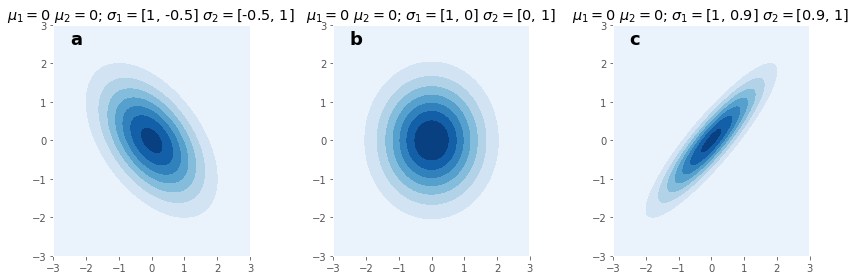

In [2]:
plt.figure(figsize=(12, 4))
gfx.plot_mvn()
plt.tight_layout()

* En la función `gfx.plot_mvn()` visualizamos distintos contornos de la función de densidad detallada arriba. 
* La figura __a__ representa una distribución donde las medias de los vectores están centrados en 0. En este punto se encontrará la mayor densidad de los casos (denotada con un azul intenso). La dirección de la relación está determinada por los elementos fuera de la diagonal principal de $\boldsymbol{\Sigma}$ (en este caso $-.5$).

* La figura __b__ representa el símil de la distribución estandarizada normal donde la densidad del contorno tiene una forma circular, en comparación a las demás figuras donde la forma es elipsoidal.

* La figura __c__ representa una distribución donde la dirección está dada por los elementos fuera de la diagonal principal. En este caso, como los valores son subtancialmente altos ($-.9$), la densidad del contorno estára mas pronunciada hacia el centro de los vectores.

* Resulta que hemos trabajado con ésta distribución antes, sólo que no la habíamos presentado formalmente. Una de sus virtudes es que permite resumir de una manera tangible la correlación entre dos variables al considerar cuál es el valor medio de ambas. Este atributo la transforma en una buena candidata para resumir el comportamiento de los datos condicionales al grupo, objetivo de los algoritmos de aprendizaje generativos.

## La idea base del algoritmo LDA

* A continuación se presenta los pasos del Análisis Lineal Discriminante con $\mathbb{Y} = 2$. La exposición de este caso es dado su relativa simplicidad y facilidad de generalizar el procedimiento cuando $\mathbb{Y} \geq 2$. 
* Para ello implementaremos una serie de gráficos que se encuentran en la función `gfx.plot_lda_sequence` que presenta de una forma visual el proceso generativo del Análisis Lineal Discriminante.

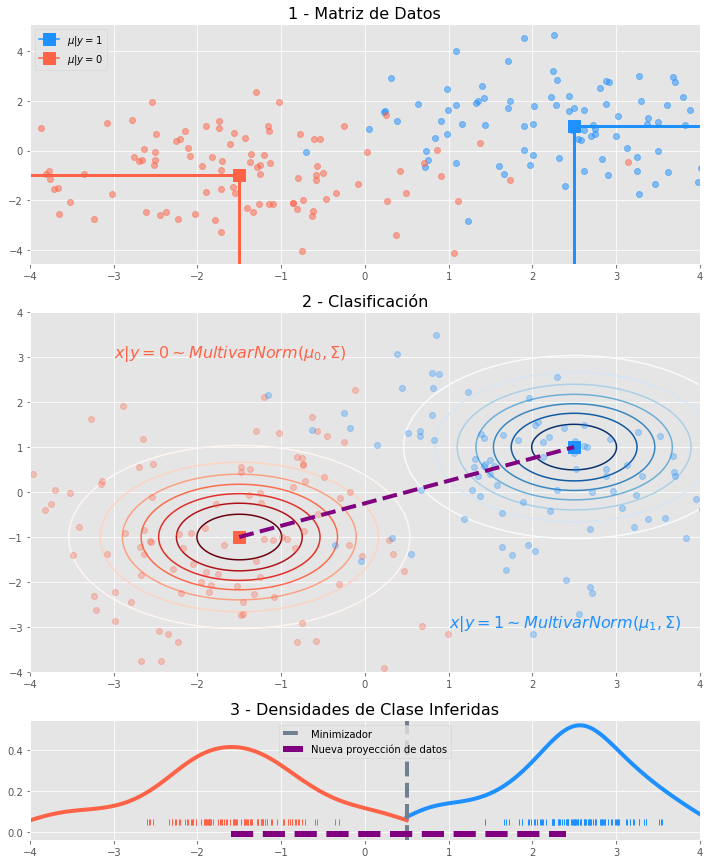

In [13]:
plt.figure(figsize=(12, 15))
gfx.plot_lda_sequence()

* El algoritmo se puede segmentar en tres grandes pasos:

### 1 - Extraer los vectores $\boldsymbol{\mu}$ para cada clase $y \in \mathbb{Y}$

* Recordemos las principales características del Análisis Lineal Discrminante: es un algoritmo __supervisado__ (tenemos conocimiento previo sobre la existencia de las clases $y\in \mathbb{Y}$)  y __generativo__ (buscamos aprender sobre las clases a partir de la distribución de los atributos $\mathbf{X}$). Esto se visualiza de mejor manera con la figura 1 del gráfico.

* En esta etapa buscamos las medias $\boldsymbol{\mu}$ de cada atributo $x \in \mathbf{X}$ condicional a la pertenencia de los datos a cada clase. Cada vector de medias $\boldsymbol{\mu}$ tendrá dos valores representativos para cada atributo en el gráfico.

### 2 - Estimar las densidades para cada clase $y \in \mathbb{Y}$ siguiendo una distribución multivariada normal $x \vert y \in \mathbb{Y} \sim \textsf{MultivarNorm}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$

* En el segundo gráfico se genera la diagramación de cada densidad. A partir de la estimación de las medias para cada clase, estimamos la función de densidad multivariada normal para cada una. Uno de los aspectos a considerar en esta etapa, es que la matriz de covarianza $\boldsymbol{\Sigma}$ se asume idéntica para ambas funciones de densidad multivariada, por lo que las elipses tienen la misma forma.

* En base a las elipses buscamos evaluar la varianza interna de cada clase, así como la varianza externa entre clases, representada con la recta púrpura trazada en la zona de mayor densidad de cada distribución. Resulta que la varianza externa es una reducción de dimensiones entre las dos clases. Parte del proceso del Análisis Lineal Discriminante es implementar esta dimensión para reescalar las observaciones empíricas del punto 1 para maximizar la separación. Generalmente esta varianza externa se rota para clarificar la división entre puntos.

### 3 - En base a las densidades de clase inferidas, seleccionar un discriminante lineal que permita reescalar las muestras en un nuevo espacio

* En base a la maximización de la varianza externa entre las clases, buscamos un discriminante lineal que reduzca la sobreposición de las observaciones de cada clase. Para clasificar una nueva observación debemos calcular la probabilidad posterior de ésta en cada una de las clases $\textsf{Pr}(y \in \mathbb{Y} \vert x)$. La probabilidad de las nuevas observaciones viene dada por las distribuciones multivariadas normales, se asigna la clase de aquella con mayor probabilidad mediante el Teorema de Bayes. 
* La recta gris es el __discriminante lineal__, que funciona como una frontera de decisión ante los puntajes predichos por el modelo. 

* Para el caso de un atributo en el modelo, los puntajes predichos obtienen de:

$$
\hat{\delta}_{y}(x) = x \cdot \frac{\hat{\mu}_{y}}{\hat{\sigma}^{2}} - \frac{\hat{\mu}_{y}}{2\hat{\sigma}^{2}} + \textsf{log}(\hat{\pi}_{y})
$$
 donde estimamos $\hat{\delta}_{k}(x)$, el puntaje de una observación específica en cada clase $y$.  Por cada clase se estima un $\hat{\mu}_{y}$, el valor promedio de las las observaciones en esa clase específica, así como su varianza $\hat{\sigma}^{2}$. Como LDA es un modelo generativo que hace uso de información previa, ésta se considera en $\hat{\pi}_{y}$ (la probabilidad observada en los datos de obtener cada clase).



# Implementando un LDA con `sklearn`

* Para implementar el modelo, utilizaremos la clase `LinearDiscriminantAnalysis` dentro del módulo `discriminant_analysis` de la librería `sklearn`. Como el algoritmo LDA es un problema de clasificación supervisada dado que tenemos conocimiento sobre la cantidad de clases y en un espacio finito Y, debemos importar de manera adicional las métricas de desempeño más comunes como `roc_auc_score`, `roc_curve`, `confusion_matrix` y `classification_report`.

* Para esta lectura trabajaremos con la conocida base de datos `iris`, donde Ronald Fisher aplicó por primera vez el Análisis Linear Discriminante en su paper _The use of multiple measurements in taxonomic problems_. Los datos de la base son 50 muestras de tres especies de flores Iris (setosa, virginica y versicolor, dando un total de 150 observaciones. Por cada una de ellas, se registraron cuatro atributos: El ancho y largo de los sépalos y pétalos. En base a la combinación de estos atributos, Ronald Fisher desarrolló un modelo discriminante para diferencar cada especie.

Partamos por incluir las librerías típicas del análisis e importar la base de datos `iris.csv`:

In [3]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# botamos la columna de index
df = pd.read_csv('iris.csv').drop(columns='Unnamed: 0')
# guardamos las etiquetas de cada clase para posterior uso.
target_label = df['Species'].unique()
df.head()


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


* Cada una de las columnas hace referencia al largo y ancho de los Sépalos y Pétalos de cada flor, medida en centímetros. Solicitemos una serie de histogramas por cada variable, representando cada clase. 
* Uno de los primeros puntos a considerar es que el ancho y largo de los Sépalos presentan una superposición importante de valores entre sí. Esto levanta indicios que pueden ser atributos con un bajo nivel de discriminación. Este punto lo volveremos a tomar más adelante.

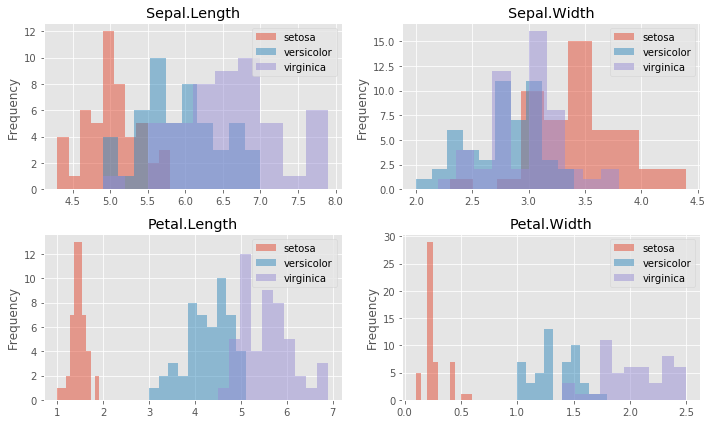

In [4]:
plt.figure(figsize=(10, 6))
for n, i in enumerate(df.drop(columns = 'Species').columns):
    plt.subplot(2, 2, n + 1)
    df.groupby('Species')[i].plot(kind='hist', alpha=.5)
    plt.legend(df['Species'].unique())
    plt.title(i)
    plt.tight_layout()

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
df['Species'] = LabelEncoder().fit_transform(df['Species'])

In [6]:
X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df.loc[:, 'Sepal.Length':'Petal.Width'],
                                                                    df['Species'],
                                                                    test_size=.33,
                                                                    random_state=11238)


* El siguiente paso es generar una instancia del clasificador. La documentación hace a una serie de hiperparámetros, de los cuales consideramos tres como relevantes:

1. `priors`: Permite ingresar la probabilidad a priori para cada clase en el algoritmo de entrenamiento. Éstos deben ser ingresados como una lista especificando la probabilidad entre 0 y 1 para cada clase. Por defecto es None. Pueden referirse a la lectura de Bayes Ingenuo para ver algunos enfoques sobre las probabilidades _a priori_.
- `tol`: Criterio de tolerancia para la decomposición de valores singulares. Por lo general éste no suele modificarse, salvo en contadas ocasiones. Una de ellas es cuando el algoritmo no alcance la decomposición, para lo cual se podría disminuír el umbral de tolerancia para analizar soluciones tentativas. Un punto a destacar es que la tolerancia por defecto $1.0e-4$ ya es relativamente baja, en comparación a los umbrales de tolerancia en otros métodos de solución como la máxima verosimilitud (donde por defecto se asume que es $1.0e-6$).
- `n_components`: Cantidad de discriminantes lineales a estimar. Por defecto el método estima que el número de discriminantes lineales a estimar es $1 - N_{\mathbb{Y}}$.
- Existen otros hiperparámetros como el método de solución (`solver`) que recomendamos no modificar sin motivos de peso. 
Nuestro primer modelo tomará los argumentos por defecto. Partimos por instanciar un objeto y posteriormente implementar el método `.fit` donde ingresamos nuestra matriz de atributos y vector objetivo.

### Digresión: Sobre los parámetros que "se recomienda no modificar"

> A estas alturas del curso probablemente se hayan encontrado varias veces con ciertos tipos de parámetros en algunos modelos que no ocupamos y que tienen nombres interesantes, como `solver` o `tol` (tolerancia). Una duda razonale es preguntarse si quizás modificando de alguna forma estos pseudo-hiperparámetros se podría obtener un mejor modelo. Antes de dar la respuesta a esa pregunta tenemos que entender la naturaleza de estos tipos de parámetros.
>
> Todo modelo de aprendizaje estadístico utlizado hasta ahora proviene de librerías que ya los tienen implementados, por lo que nunca vemos en realidad como es calculado computacionalmente nuestro modelo (es distinto a como lo calculamos en el papel, no basta tener la función objetivo solamente). Cuando uno de nuestros modelos es entrenado, se generan muchos calculos matriciales con nuestra matriz de atributos, descomposiciones de matrices e iteraciones para encontrar mínimos/máximos de funciones.
>
> Muchas veces el problema en cuestión se reduce a encontrar la solución a un sistema matricial (similar a la forma que tiene una equación de primer grado: $Ax=b$) mal condicionado. Para resolverlo hacemos uso de derivadas matriciales y operaciones matriciales, las cuales son costosas en términos computacionales y sólo pueden aumentar en su costo en la medida que ingresamos más datos.
>
>El parámetro `solver` especifica el método numérico para calcular la solución al sistema. Mediante la especificación de éste en un modelo, podemos obtener estimaciones con un mayor grado de eficiencia. Por ejemplo, cuando implementamos modelos con matrices dispersas, el solver por defecto `liblinear` será mucho más lento que `sag` o `saga`. 
>
>El parámetro `tol` regula la optimización de la función objetivo. Dado que buscamos que el algoritmo alcance un mínimo/máximo, la manera más aceptada des mediante la aproximación iterativa. Por cada paso que mi algoritmo vuelva a iterar, éste se acercará a un mínimo/máximo. Si tenemos un punto (que representa nuestro estimador) que se acerca cada vez más al punto de inflexión de la función objetivo, llegará una situación donde la diferencia entre el punto y el mínimo/máximo de esa función será casi indistinguible. Mediante la tolerancia podemos ingresar un umbral que ordene la detención del algoritmo posterior a ese punto.
>
> Finalmente, para responder la pregunta planteada al inicio: No, modificar estos valores (a menos que sean casos de borde) no permite mejorar el modelo en sí mismo, la razón está en que el problema no cambia, solo cambia la forma en la que encontramos la solución o el nivel de exactitud de la solución. De todas formas este es un tema interesante que, les guste o no, tendremos que volver a ver hacia el final del curso cuando veamos redes neuronales.

In [7]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_mat, y_train_vec)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

* En base a este objeto instanciado podemos extraer información sobre el porcentaje de casos en cada clase estimada con `priors_`, las medias de cada atributo en cada clase `means_` y la varianza explicada por cada uno de los discrminantes lineales estimados.

* Un aspecto a considerar es en las medias de cada clase es la similitud de atributos entre las últimas dos, correspondientes a versicolor y virginica. 
* Dado que no conocíamos información _a priori_ sobre la probabilidad de ocurrencia de cada clase, el modelo las asumió a partir de los datos observados.

In [8]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n", 
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", 
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.32 0.35 0.33] 

Medias de atributos en cada clase
 [[5.08 3.54 1.47 0.27]
 [5.96 2.8  4.32 1.35]
 [6.57 2.96 5.52 2.05]] 

Varianza explicada por cada discriminante
 [0.99 0.01] 



* Mediante `lda_model.coef_` podemos extraer información sobre la combinación lineal de parámetros que se implementaron para generar las fronteras de decisión. Cada una 

In [9]:
lda_model.coef_

array([[  6.00531776,  11.58512358, -14.96625342, -21.90925818],
       [ -1.832109  ,  -3.70832024,   4.79020568,   1.82865095],
       [ -3.88019252,  -7.30099231,   9.43220941,  19.30586298]])

* Como todo modelo de predicción establecido desde el aprendizaje de máquinas, nuestro objetivo es medir el desempeño. Para ello implementamos un par de funciones de diagnóstico gráfico en nuestro archivo auxiliar. 
* Partamos por realizar las predicciones de clase (las predicciones a realizar son exactamente las mismas para la mayoría de los modelos de clasificación).

In [10]:
lda_class_pred = lda_model.predict(X_test_mat)
lda_class_pred[:20]

array([2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0])

* Ahora implementaremos una matriz de confusión con `gfx.plot_confusion_matrix`. El gráfico muestra que el modelo clasifica correctamente todas las observaciones setosa, pero presenta complicaciones respecto a la clasificación entre versicolor y virginica.

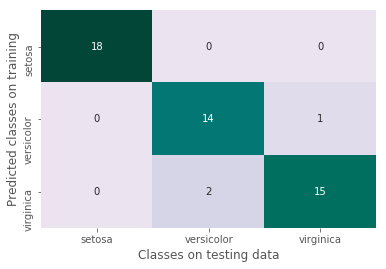

In [11]:
gfx.plot_confusion_matrix(y_test_vec, lda_class_pred, classes_labels=target_label)

* Solicitemos las medidas de Precision, Recall y F1 para cada una de las clases. De igual manera a como lo hicimos con la matriz de confusión, tenemos una función que reporta de forma gráfica las métricas para cada una de las clases y el promedio general del clasificador.

* La línea roja representa el promedio general de cada una de las métricas. Para este caso es de .94, lo cual refleja un nivel adecuado de clasificación. Resulta que si comparamos las métricas respecto a esta media, observamos que hay situaciones donde las clases versicolor y virginica tienen un desempeño inferior a la media.

* Las observaciones clasificadas como versicolor presentan un desempeño inferior respecto a la precision de las predicciones, por lo que falla en precedir correctamente las etiquetas positivas. Las observaciones clasificadas como virginica presentan un desempeño inferior respecto al recall de las predicciones, por lo que su desempeño de identificar verdaderos positivos respecto a las predicciones correctas es inferior al desempeño general del modelo.

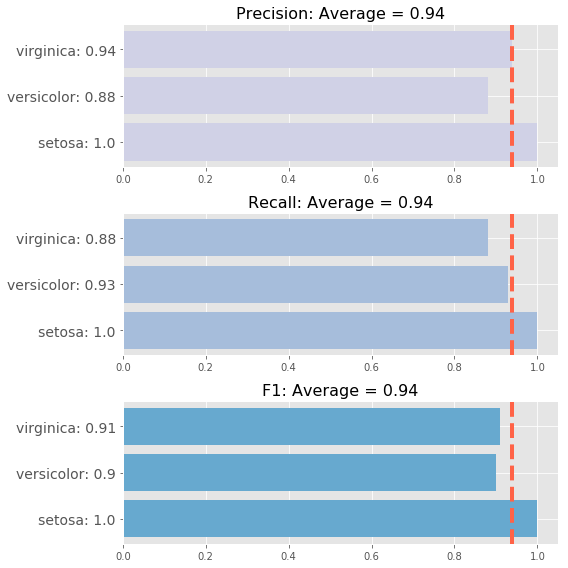

In [12]:
plt.figure(figsize=(8, 8))
gfx.plot_class_report(y_test_vec, lda_class_pred, classes_labels=target_label)

* Otro de los aspectos relevantes a considerar en la clasificación multiclases realizada con LDA son las fronteras de decisión. Para ello implementamos la función `gfx.probability_contours` que visualiza cuáles son los rangos de clasificación entre dos atributos. 
* Si bien la limitante de este ejercicio es que impide incluír más de 2 variables, es un buen aproximado para tener un conocimiento tangible del modelo. La función acepta una clase `sklearn` que representa un modelo, una matriz de atributos y un vector objetivo donde buscar los atributos específicos `x1` y `x2` a analizar.

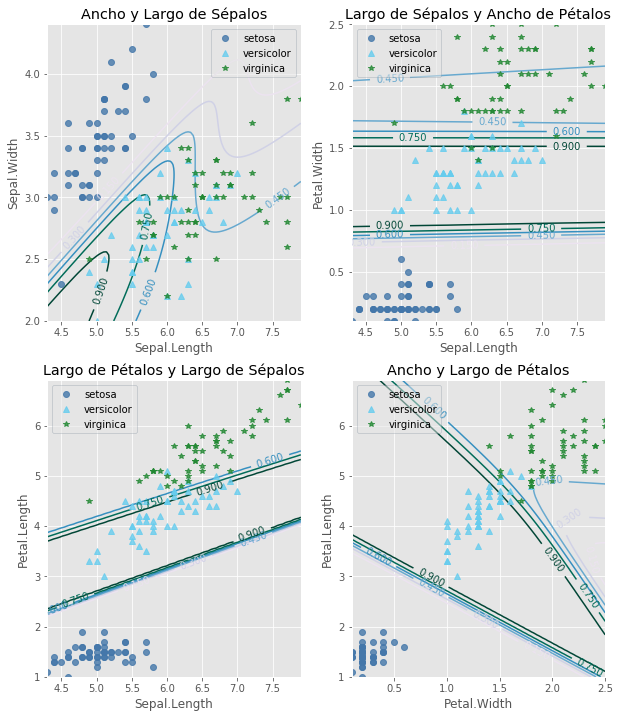

In [13]:
x_mat = df.loc[:, 'Sepal.Length':'Petal.Width']
y_vec = df['Species']
plt.figure(figsize=(10, 12))
plt.subplot(2, 2, 1)
gfx.probability_contours(LinearDiscriminantAnalysis(),x_mat,y_vec,
                         'Sepal.Length', 'Sepal.Width', classes_labels=target_label)
plt.title('Ancho y Largo de Sépalos');
plt.subplot(2, 2, 2)
gfx.probability_contours(LinearDiscriminantAnalysis(),x_mat,y_vec,
                         'Sepal.Length', 'Petal.Width', classes_labels=target_label)
plt.title('Largo de Sépalos y Ancho de Pétalos');
plt.subplot(2, 2, 3)
gfx.probability_contours(LinearDiscriminantAnalysis(),x_mat,y_vec,
                         'Sepal.Length', 'Petal.Length', classes_labels=target_label)
plt.title('Largo de Pétalos y Largo de Sépalos');
plt.subplot(2, 2, 4)
gfx.probability_contours(LinearDiscriminantAnalysis(),x_mat,y_vec,
                         'Petal.Width', 'Petal.Length', classes_labels=target_label)
plt.title('Ancho y Largo de Pétalos');

* Si nos fijamos respecto al gráfico de Ancho y Largo de Sépalos, observamos que el modelo tiene dificultades en reconocer más de una dimensión discriminante. Separa bien los casos setosa, pero es incapaz de diferenciar versicolor de virginicas. Volviendo al análisis exploratorio, observamos que en los histogramas para éstas variables hay una superposición importante entre estas dos clases para el ancho y largo de los sépalos.

* Cuando incluímos información sobre los pétalos, el modelo mejora susbtancialmente en la capacidad de reconocer $1 = N_{\mathbb{Y}}$ clases, lo que conlleva a la división mediante dos discrminantes lineales.

## Análisis Cuadrático Discriminante

* A diferencia de LDA, donde $\boldsymbol{\Sigma}$ se asume constante para cada clase $y \in \mathbb{Y}$, en el análisis cuadrático discriminante asume que los atributos de la matriz de datos se distribuyen de forma multivariada normal __condicional__ a las clases. Así, cada clase a estimar su densidad multivariada dependerá de una matriz de covarianza específica a la clase.

* Para implementar un Análisis Cuadrático Discriminante importamos la clase `QuadraticDiscriminantAnalysis` dentro del módulo `discriminant_analysis` de la librería `sklearn`.

* De similar manera, los parámetros `priors` y `tol` se manejan de similar manera que en la versión Lineal. El parámetro`reg_params` permite regularizar (mediante Elastic Net) que penaliza la covarianza estimada.

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis().fit(X_train_mat, y_train_vec)
qda_class_pred = qda_model.predict(X_test_mat)

* El nuevo clasificador mejora las clasificaciones en la tercera clase, pero erra en una (lo observado es 1 y lo predicho es 2). A grandes rasgos el desempeño del modelo predictivo aumenta.

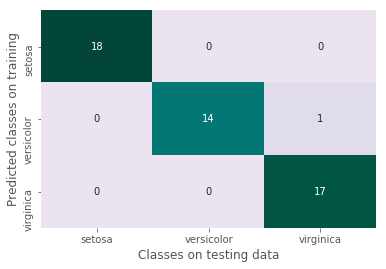

In [15]:
gfx.plot_confusion_matrix(y_test_vec, qda_class_pred, classes_labels=target_label)

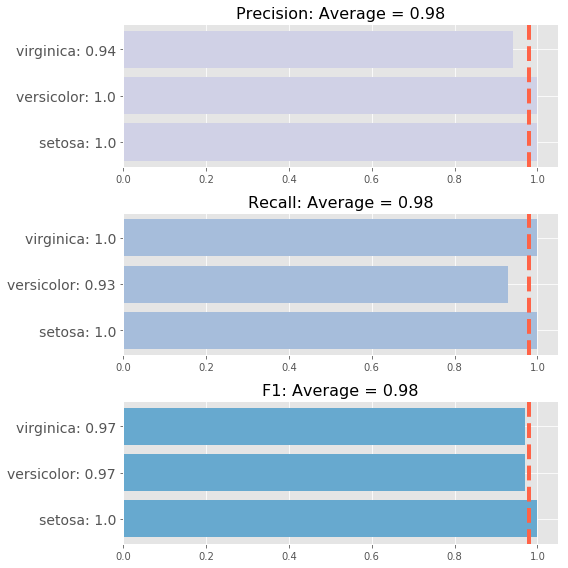

In [16]:
plt.figure(figsize=(8, 8))
gfx.plot_class_report(y_test_vec, qda_class_pred, classes_labels=target_label)

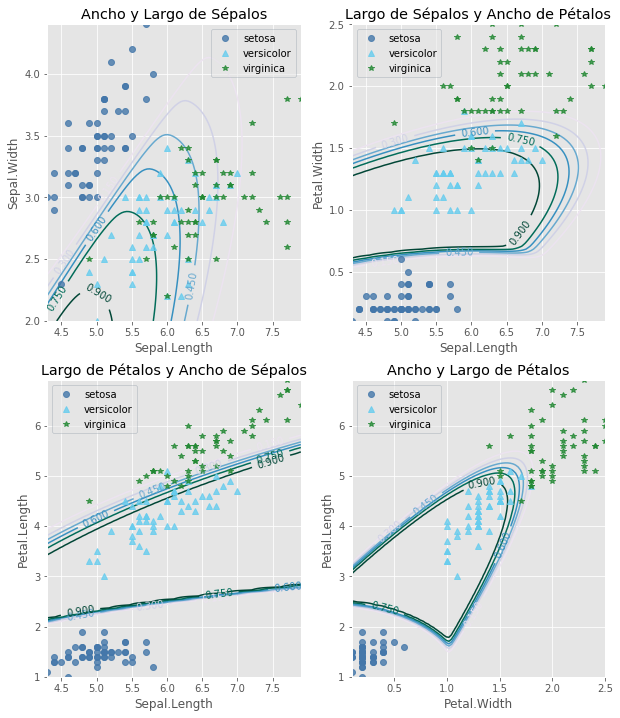

In [17]:
x_mat = df.loc[:, 'Sepal.Length':'Petal.Width']
y_vec = df['Species']
plt.figure(figsize=(10, 12))
plt.subplot(2, 2, 1)
gfx.probability_contours(QuadraticDiscriminantAnalysis(),x_mat,y_vec,
                         'Sepal.Length', 'Sepal.Width', classes_labels=target_label)
plt.title('Ancho y Largo de Sépalos');
plt.subplot(2, 2, 2)
gfx.probability_contours(QuadraticDiscriminantAnalysis(),x_mat,y_vec,
                         'Sepal.Length', 'Petal.Width', classes_labels=target_label)
plt.title('Largo de Sépalos y Ancho de Pétalos');
plt.subplot(2, 2, 3)
gfx.probability_contours(QuadraticDiscriminantAnalysis(),x_mat,y_vec,
                         'Sepal.Length', 'Petal.Length', classes_labels=target_label)
plt.title('Largo de Pétalos y Ancho de Sépalos');
plt.subplot(2, 2, 4)
gfx.probability_contours(QuadraticDiscriminantAnalysis(),x_mat,y_vec,
                         'Petal.Width', 'Petal.Length', classes_labels=target_label)
plt.title('Ancho y Largo de Pétalos');

* Tal como lo dice el algoritmo, la principal característica del algoritmo cuadrático es que genera discriminantes cuadráticos. Esto se aprecia en los gráficos de contorno de probabilidad generados arriba.
* Este comportamiento es posible dado que relajamos el supuesto de la covarianza compartida para cada clase estimada. Para los casos donde incluímos el Largo de Sépalos y Ancho de Pétalos, así como en el caso de Ancho y Largo de Pétalos, se observa que el contorno predicho se adapta de mejor manera a las observaciones.


# Apreciaciones

* A continuación se detallan algunos vínculos existentes entre los modelos generativos LDA, PCA y Regresión Logística.


## Análisis Lineal Discriminante vs Análisis de Componentes Principales


![](img/raschka_lda_pca.png)

* El análisis lineal discriminante y el análisis de componentes principales son transformaciones lineales que permiten reexpresar un nuevo espacio lineal para reducir la cantidad de dimensiones. Una de las principales diferencias es la naturaleza del entrenamiento. 
* PCA es un método no supervisado que no adquiere información sobre las clases en una matriz de datos, por lo que busca maximizar la varianza __dentro__ de ésta. 
* En contraparte, LDA busca maximizar la __varianza externa__ entre cada clase (también conocida como los componentes lineales). Para lograr esto se vale de información dada sobre la pertenencia de cada observación en las clases.

* Por lo general, LDA presenta mejores resultados cuando buscamos colapsar los atributos en función de las clases existentes. PCA se puede implementar como un paso previo para reducir la dimensionalidad, antes de asignar clases en base a la maximización de la varianza.

# Análisis Lineal Discriminante vs Regresión Logística

* La regresión logística es menos exigente y más robusta a variados casos que LDA. Aún así, si se cumplen las condiciones de normalidad multivariada, LDA será asintóticamente eficiente, permitiendo mejores clasificaciones con un menor tamaño del training set (en comparación a la regresión logística y otros métodos).

# Referencias

* Hastie, T; Tibshirani, T; Friedman, J. 2008. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch4: Linear Methods for Classification.
* Murphy, K. 2012. Machine Learning: A Probabilistic Perspective. Cambridge, MA: Massachusetts Institute of Technology Press. Ch4: Gaussian models. 